# The Movies Dataset TF-IDF Content-Based Recommendation

##Понимание данных:

### Набор данных

Дан набор данных, содержащий информацию о 45,000 фильмах, выпущенных до июля 2017 года. Набор данных представлен на ресурсе Kaggle по ссылке https://www.kaggle.com/rounakbanik/the-movies-dataset
где представлено следующее описание составляющих файлов (выполнен перевод на русский язык):

`movies_metadata.csv:` Основной файл метаданных фильмов. Содержит информацию о 45 000 фильмов, представленных в наборе данных Full MovieLens. В таблицы представлены плакаты, фоны, бюджет, доход, даты выпуска, языки, страны-производители и компании.

`keywords.csv:` Содержит ключевые слова сюжета для наших фильмов MovieLens. Доступен в виде строкового объекта JSON.

`credits.csv:` Состоит из информации об актерах и съемках всех наших фильмов. Доступен в виде строкового объекта JSON. 

`links.csv:` Файл содержит идентификаторы TMDB и IMDB всех фильмов, представленных в наборе данных Full MovieLens.

`links_small.csv:` Содержит идентификаторы TMDB и IMDB небольшого подмножества из 9000 фильмов полного набора данных.

`ratings_small.csv:` Подмножество 100 000 оценок от 700 пользователей на 9 000 фильмов.

`ratings.csv `- файл, содержащий полный список оценок, выставленных пользователями фильмам



Рассмотрим подробнее две таблицы:

*   `movies_metadata.csv `
*   `ratings.csv `

In [3]:
! pip install --upgrade --no-cache-dir gdown
!gdown 18PC17_iR9f4WuGIKLSHU3drPt1jdCofA
!gdown 1wTPUbZx4C2zhdqzPk3yxKyVZJIxQcsvy

In [214]:
import pandas as pd
import numpy as np
import operator
from collections import defaultdict
from collections.abc import Callable
from scipy.stats import pearsonr
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

Начинаем с анализа датафрейма movies_metadata

In [2]:
metadata = pd.read_csv("movies_metadata.csv")
print(f'Всего строк: {len(metadata)}')

Всего строк: 45466


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Задание 1

Удадите из датафрейма metadata строки, в которых отсутствует описание. Обратите внимание, что у некоторых фильмов формально описание есть, но там написано No overview found, No overview, No movie overview available, Released. Такие строки тоже нужно удалить. 

In [3]:
values_to_drop = ('No overview found', 'No overview', 'No movie overview available', 'Released')
metadata = metadata[(~metadata.overview.isin(values_to_drop)) & (pd.notnull(metadata.overview))].reset_index(drop=True)
print(f'Всего строк: {len(metadata)}')

Всего строк: 44507


## Задание 2

Оставьте в датафрейме столбцы `'id', 'imdb_id', 'overview', 'title'`. Выведите 10 случайных строк.

In [4]:
metadata = metadata[['id', 'imdb_id', 'overview', 'title']]
metadata.sample(10)

,id,imdb_id,overview,title
29836,17381,tt0085204,Teens P.J. and Goose get their thrills on BMX ...,BMX Bandits
23112,44721,tt0065989,A comedy/drama about an unlikely pair who shar...,Little Fauss and Big Halsy
33303,90147,tt1371585,"A criminal, a bank clerk and a police officer ...",Life Without Principle
32460,169794,tt2452384,"On the eve of an annual sibling reunion, a tro...",All That I Am
4161,824,tt0203009,A celebration of love and creative inspiration...,Moulin Rouge!
31098,74645,tt0198769,"Voltaire, a 16th century author was furious th...",Mondo Candido
28985,229328,tt2936470,A woman leaves her seaside hometown to search ...,Electricity
15101,4180,tt0090206,"Three young men (Jacques, Pierre and Michel) s...",Three Men and a Cradle
42238,380075,tt4250566,A Roma boy is placed in a mental hospital and ...,Fog in August
38996,369605,tt4085130,The concept of an elevator to space is not new...,Sky Line


## Задание 3

In [5]:
ratings = pd.read_csv('ratings.csv')
print(f'Всего строк: {len(ratings)}')

Всего строк: 26024289


In [6]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148
6,1,2762,4.5,1425941300
7,1,2918,5.0,1425941593
8,1,2959,4.0,1425941601
9,1,4226,4.0,1425942228


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


Убедимся в отсутствии пропусков

In [8]:
pd.isnull(ratings).sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Объедините датафреймы `metadata` и `ratings` в один. Обратите внимание, что `'id'` в  `metadata`, этот тот же самый идентификатор, что и `'movie_id'` и `ratings`. Объединять нужно по этому идентификатору (также обратите внимание на его тип данных).

In [9]:
metadata['id'] = metadata['id'].astype(np.int64)

In [142]:
data_df = metadata.merge(ratings, left_on='id', right_on='movieId')
data_df

,id,imdb_id,overview,title,userId,movieId,rating,timestamp
0,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,1923,862,3.0,858335006
1,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,2103,862,5.0,946044912
2,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,5380,862,1.0,878941641
3,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,6177,862,4.0,859415226
4,862,tt0114709,"Led by Woody, Andy's toys live happily in his ...",Toy Story,6525,862,4.0,857388995
...,...,...,...,...,...,...,...,...
11396975,111109,tt2028550,An artist struggles to finish his work while a...,Century of Birthing,33940,111109,2.5,1405878785
11396976,111109,tt2028550,An artist struggles to finish his work while a...,Century of Birthing,172224,111109,3.0,1399502972
11396977,111109,tt2028550,An artist struggles to finish his work while a...,Century of Birthing,210792,111109,3.0,1467090449
11396978,111109,tt2028550,An artist struggles to finish his work while a...,Century of Birthing,225396,111109,3.5,1399302912


## Задание 4

Появились ли пропуски в получившемся после объединения датафрейме? Если появились, то ответьте на вопрос "почему?" и удалите строки с пропусками.

Выведите размеры получившегося датафрейма и 10 случайных записей в нём.

In [143]:
data_df.isnull().sum()

id            0
imdb_id      47
overview      0
title         0
userId        0
movieId       0
rating        0
timestamp     0
dtype: int64

Заметим, что в столбце `'imdb_id'` появилось 47 пропусков. Можно предположить, что причиной этого стало наличие пропусков в исходном датасете в столбце `'imdb_id'`. При процедуре объединения двух датасетов могут мерджиться строки, как раз содержащие пропуски, что и является следствием их возникновения в новом датасете. Убедимся, что в metadata действительно имеются пропуски в столбце `'imdb_id'`:

In [144]:
metadata.isnull().sum()

id           0
imdb_id     15
overview     0
title        3
dtype: int64

Видно, что в искомом столбце содержится 15 пропусков. Наше предположение подтвердилось. Удалим эти строки:

In [145]:
print(f'Размер датафрейма до удаления: {data_df.shape}')
data_df = data_df[pd.notnull(data_df.imdb_id)]
print(f'Размер датафрейма после удаления: {data_df.shape}')

Размер датафрейма до удаления: (11396980, 8)
Размер датафрейма после удаления: (11396933, 8)


In [146]:
# выведем 10 случайных строк

data_df.sample(10)

,id,imdb_id,overview,title,userId,movieId,rating,timestamp
7654460,1667,tt0428803,"Every year, thousands of Antarctica's emperor ...",March of the Penguins,60057,1667,4.0,904070152
5253954,1682,tt0058379,The 4th film in the Godzilla franchise restore...,Mothra vs. Godzilla,239679,1682,3.0,960588602
9261913,1266,tt0421073,Tom Ludlow is a disillusioned L.A. Police Offi...,Street Kings,144362,1266,3.5,1309190055
7666749,1665,tt0403217,The life and struggles of a notorious rock mus...,Last Days,93234,1665,2.0,1121999112
9858948,1244,tt0764639,Achim Bornhak's movie focuses on the restless ...,Eight Miles High,94743,1244,4.0,917366687
2533515,4975,tt0119577,Biography of the British painter Francis Bacon...,Love Is the Devil: Study for a Portrait of Fra...,39152,4975,5.0,1439145725
9228115,2282,tt0086650,A portrait of youth in bloom; a tale of one fa...,À nos amours,261840,2282,5.0,946661500
3143632,253,tt0070328,James Bond must investigate a mysterious murde...,Live and Let Die,94802,253,2.5,1373655005
3783793,8810,tt0082694,Max Rockatansky returns as the heroic loner wh...,Mad Max 2: The Road Warrior,49907,8810,3.0,1171653808
7978869,1690,tt0450278,Three backpackers head to a Slovakian city tha...,Hostel,120392,1690,3.5,1337172171


## Задание 5

Возьмите случайного пользователя (проверьте, чтобы у него было достаточное количество оценок). Сформируйте для этого пользователя рекомендацию методом коллаборативной фильтрации. Оцените качество этой рекомендации.


Повторите эти рассчеты для большого числа пользователей и дайте интегральную оценку.

In [72]:
class CollaborativeFiltering:
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.users = df['user'].unique()
        self.ratings = {user: self.get_ratings(user) for user in self.users}
        
    def get_ratings(self, user: int) -> dict:
        user_df = self.df.query(f'user == {user}')
        return dict(zip(user_df['movie'], user_df['rating']))
    
    def common_movies(self, user_1: int, user_2: int) -> pd.DataFrame:
        movies_1 = self.ratings[user_1]
        movies_2 = self.ratings[user_2]
        return pd.merge(
            pd.DataFrame(data={'movie': movies_1.keys(), 'rating': movies_1.values()}),
            pd.DataFrame(data={'movie': movies_2.keys(), 'rating': movies_2.values()}),
            on='movie',
            suffixes=['_1', '_2']
        )
    
    def euclid_distance(self, x: list, y: list, power=2) -> float:
        distance = 0
        for x_value, y_value in zip(x, y):
            distance += (x_value - y_value) ** power
        return distance ** (1 / power)
    
    def similarity_distance(self, common_movies_df: pd.DataFrame) -> float:
        if len(common_movies_df) == 0:
            return 0
        return 1 / (1 + self.euclid_distance(common_movies_df['rating_1'], common_movies_df['rating_2']))
    
    def remove_user(self, user: int) -> list:
        return list(set(self.users) - set([user]))
    
    def similarities(self, user: int) -> dict:
        users = self.remove_user(user)
        return {cur_user: self.similarity_distance(self.common_movies(user, cur_user)) for cur_user in users}
        
    def other_movies_of_user(self, user_1: int, user_2: int) -> dict:
        return {movie: rating for movie, rating in self.ratings[user_2].items()
                    if movie not in self.ratings[user_1]}
    
    def other_movies(self, user: int) -> dict:
        users = self.remove_user(user)
        return {cur_user: self.other_movies_of_user(user, cur_user) for cur_user in users}
    
    def recommendations(self, user: int) -> dict:
        similarities = self.similarities(user)
        other_movies = self.other_movies(user)
        
        recommendations = defaultdict(lambda: 0)
        total_similarities = defaultdict(lambda: 0)
        for cur_user, movies in other_movies.items():
            for movie, rating in movies.items():
                recommendations[movie] += similarities[cur_user] * rating
                total_similarities[movie] += similarities[cur_user]
        
        recommendations = {movie: rating / total_similarities[movie]
                           for movie, rating in recommendations.items()}
                
        return dict(sorted(recommendations.items(), key=operator.itemgetter(1), reverse=True))

In [122]:
class Assessment:
    
    def __init__(self, df: pd.DataFrame):
        self.col_filtering = CollaborativeFiltering(df)
        self.df = df
        
    def assess_user_recommendations(self, user: int, cv: KFold, function: Callable) -> np.array:
        user_df = self.df.query(f'user == {user}')
        errors = []
        
        for train_index, test_index in cv.split(user_df):
            df_test = user_df.iloc[test_index]
            df_train = self.df[~((self.df.user.isin(df_test.user)) & (self.df.movie.isin(df_test.movie)))]
            recommendations_df = self.pred_recommendations(user, df_train, df_test)
            error = function(recommendations_df['rating'], recommendations_df['pred'])
            errors.append(error)
            
        return np.array(errors)
            
    def pred_recommendations(self, user: int, df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
        col_filtering = CollaborativeFiltering(df_train)
        recommendations = col_filtering.recommendations(user)
        return pd.merge(
            user_df,
            pd.DataFrame(data={
                'movie': recommendations.keys(),
                'pred': recommendations.values()
            }),
            on='movie'
        )

In [161]:
data_df = data_df.rename(columns={
    'userId': 'user',
    'movieId': 'movie',
})[['user', 'movie', 'rating']]

Для более быстрого процесса обучения возьмем 500 пользователей, давшими наибольшое количество оценок. На основе полученного датасета будем обучать наши данные и делать рекоммендации:

In [178]:
top_500_users_with_most_ratings = data_df['user'].value_counts().head(500).index.values
df = data_df[data_df['user'].isin(top_500_users_with_most_ratings)].reset_index(drop=True)
df

,user,movie,rating
0,8659,862,4.0
1,13839,862,4.0
2,17211,862,5.0
3,18274,862,4.5
4,20159,862,3.0
...,...,...,...
439626,8659,111109,3.0
439627,33940,111109,2.5
439628,172224,111109,3.0
439629,210792,111109,3.0


In [181]:
user = 45811
ratings_count = len(df.query(f'user == {user}'))
print(f'Количество оценок пользователя {user}: {ratings_count}')

Количество оценок пользователя 45811: 3544


Составим рекомендацию из 30 фильмов для просмотра данному пользователю, которые алгоритм предсказал как те, в которых пользователь поставит более высокую оценку:

In [193]:
rec_sys = CollaborativeFiltering(df)
recommendations = rec_sys.recommendations(user)
recommendations_df = pd.DataFrame(data={
    'movie': recommendations.keys(),
    'rating': recommendations.values() 
})
recommendations_df.head(30)

,movie,rating
0,170689,5.000000
1,132912,5.000000
2,129360,5.000000
3,164278,5.000000
4,74406,5.000000
5,74491,5.000000
6,140465,5.000000
7,123109,5.000000
8,68590,5.000000
9,168478,5.000000


Оценим качество этой рекомендации для всех фильмов для данного пользователя. Сделаем это с помощью кросс-валидации по 5 фолдам, где в каждом наборе обучающих фолдов будут исключены фильмы, находящиеся в тестовой выборке. В качестве метрики измерения качества рекомендаций возьмем **RMSE**.

In [195]:
assessment = Assessment(df)
mse_errors = assessment.assess_user_recommendations(user, cv=KFold(n_splits=5), function=mean_squared_error)
rmse_errors = np.sqrt(mse_errors)
print(f'Значения RMSE на каждом из фолдов: {rmse_errors}')
print(f'Среднее значение RMSE на всех фолдах: {np.mean(rmse_errors)}')

Значения RMSE на каждом из фолдов: [0.85557055 0.8406599  0.80567254 0.77514282 0.78184203]
Среднее значение RMSE на всех фолдах: 0.8117775678247755


Проведем оценку на большем числе пользователей. Возьмем 50 пользователей с наибольшим количеством оценок и для каждого из них будем считать среднее значение **RMSE**. Полученный набор значений для каждого из 50 пользователей усредним и получим общую среднюю оценку.

In [197]:
top_n = 50
top_50_users_with_most_ratings = df['user'].value_counts().head(top_n).index.values
rmse_values = []
for user in top_50_users_with_most_ratings:
    mse_errors = assessment.assess_user_recommendations(user, cv=KFold(n_splits=5), function=mean_squared_error)
    rmse_values.append(np.mean(np.sqrt(mse_errors)))
print(f'Среднее значение RMSE для {top_n} пользователей: {np.mean(rmse_values)}')

Среднее значение RMSE для 50 пользователей: 0.8818943521883825


Text(0.5, 1.0, 'Распределение средних ошибок RMSE')

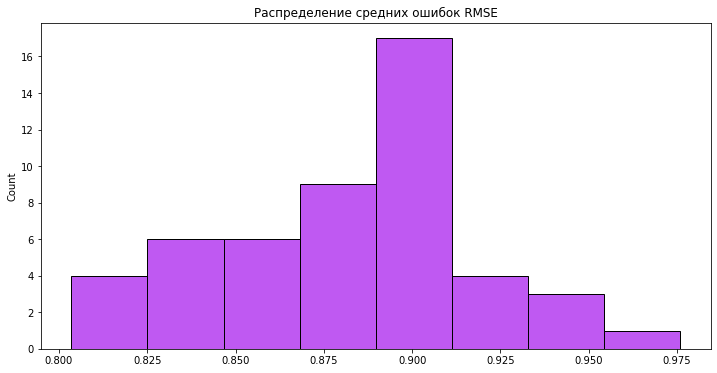

In [217]:
plt.figure(figsize=(12, 6))
sns.histplot(rmse_values, bins=8, color='#A2E')
plt.title('Распределение средних ошибок RMSE')

## Задание 6

Используйте метод Term Frequency Inverse Document Frequency (TF-IDF), чтобы отфильтровать фильмы, похожие (используйте для этого косинусное расстояние) на те, которые пользователь высоко оценил. 

Оцените качество такой рекомендации.